<a href="https://colab.research.google.com/github/hida0/ESAA/blob/2022-1-Study/Study_Week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [주차수요 예측 AI 경진대회]
아파트 단지 내 필요한 주차대수는 ①법정주차대수 ②장래주차수요 중 큰 값에 따라 결정하게되어 있어, 정확한 ②장래주차수요의 산정을 필요로 합니다.

현재 ②장래주차수요는 ‘주차원단위’와 ‘건축연면적’을 기초로하여 산출되고 있으며, ‘주차원단위’는 신규 건축예정 부지 인근의 유사 단지를 피크 시간대 방문하여 주차된 차량대수를 세는 방법으로 조사하고 있습니다.

- 평가산식 : MAE(Mean Absolute Error)
- Public 평가 : 전체 Test 데이터 중 무작위 33% (50단지)
- Private 평가 : 전체 Test 데이터 중 나머지 67% (100단지)


### 1. 라이브러리 및 데이터 로드

In [ ]:
import os 
import glob
import pandas as pd
import numpy as np

import plotly 
import plotly.express as px
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
#한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [ ]:
# plotly 그래프 업로드
pd.options.plotting.backend = 'plotly'
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

# 옵션 설정
pd.set_option('display.max_columns', None)
matplotlib.rcParams['axes.unicode_minus'] = False

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/ESAA/2022-1 Study/Week3/train.csv")
print(train.shape)
train.head(3)

(2952, 15)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [ ]:
test = pd.read_csv("/content/drive/MyDrive/ESAA/2022-1 Study/Week3/test.csv")
print(test.shape)
test.head(3)

(1022, 14)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0


In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/ESAA/2022-1 Study/Week3/sample_submission.csv")
print(submission.shape)
submission.head(3)

(150, 2)


,code,num
0,C1072,0
1,C1128,0
2,C1456,0


### 2. 데이터 전처리
### 2-1. 컬럼명 변경
- 도보 10분거리 내 지하철역 수(환승노선 수 반영) → **지하철**
- 도보 10분거리 내 버스정류장 수 → **버스**

In [ ]:
train.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형', '임대보증금', '임대료', '지하철', '버스', '단지내주차면수', '등록차량수']
test.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형', '임대보증금', '임대료', '지하철', '버스', '단지내주차면수']

In [ ]:
train.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


### 2. 데이터 전처리
### 2-2. 데이터 타입 및 결측치 확인
1) train data 데이터 타입 확인
- 임대보증금
- 임대료

2) train data 결측치 확인
- 임대보증금
- 임대료
- 지하철
- 버스

In [ ]:
train.dtypes

단지코드         object
총세대수          int64
임대건물구분       object
지역           object
공급유형         object
전용면적        float64
전용면적별세대수      int64
공가수         float64
자격유형         object
임대보증금        object
임대료          object
지하철         float64
버스          float64
단지내주차면수     float64
등록차량수       float64
dtype: object

In [ ]:
train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       569
임대료         569
지하철         211
버스            4
단지내주차면수       0
등록차량수         0
dtype: int64

### 2. 데이터 전처리
### 2-2. 데이터 타입 및 결측치 확인
1) test data 데이터 타입 확인
- 임대보증금
- 임대료

2) test data 결측치 확인
- 자격유형
- 임대보증금
- 임대료
- 지하철


In [ ]:
test.dtypes

단지코드         object
총세대수          int64
임대건물구분       object
지역           object
공급유형         object
전용면적        float64
전용면적별세대수      int64
공가수         float64
자격유형         object
임대보증금        object
임대료          object
지하철         float64
버스          float64
단지내주차면수     float64
dtype: object

In [ ]:
test.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          2
임대보증금       180
임대료         180
지하철          42
버스            0
단지내주차면수       0
dtype: int64

### 2. 데이터 전처리
### 2-3. 결측치 대체
#### 1) **지하철 / 버스**
- train data : 지하철 & 버스 결측치를 0으로 대체, 정수화
- test data : 지하철 결측치를 0으로 대체, 정수화

In [ ]:
train[['지하철', '버스']] = train[['지하철', '버스']].fillna('0').astype(int)
test[['지하철']] = test[['지하철']].fillna('0'). astype(int)

### 2. 데이터 전처리
### 2-3. 결측치 대체
#### 2) **자격유형**
- test data의 **단지코드**가 **C2411**와 **C2253**인 경우 자격유형에 결측치가 존재한다.
- 단지코드, 임대건물구분, 지역 등이 동일한 샘플의 자격유형 값을 참고하여 대체한다.
 - C2411 자격유형 → 'A'
 - C2253 자격유형 → 'C'

In [ ]:
test[test['자격유형'].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0,2.0,173.0


In [ ]:
test[(test['단지코드']=='C2411') | (test['단지코드']=='C2253')].head(10)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000,100720,0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000,100720,0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000,100720,0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000,171480,0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000,83020,0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000,83020,0,2.0,173.0
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,NaN,NaN,0,2.0,173.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,NaN,NaN,0,2.0,173.0


In [ ]:
# 196번
test.loc[(test['단지코드']=='C2411') & (test['자격유형'].isnull()), '자격유형'] = 'A'

# 258번
test.loc[(test['단지코드']=='C2253') & (test['자격유형'].isnull()), '자격유형'] = 'C'

test[(test['단지코드']=='C2411') | (test['단지코드']=='C2253')].head(10)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000,100720,0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000,100720,0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000,100720,0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,A,71950000,37470,0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000,171480,0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,C,2249000,44770,0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000,83020,0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000,83020,0,2.0,173.0
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,NaN,NaN,0,2.0,173.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,NaN,NaN,0,2.0,173.0


### 2. 데이터 전처리
### 2-3. 결측치 대체
#### 3) **임대보증금 / 임대료**
- **공급유형**이 '**임대상가**'/'**공공분양**'/'**행복주택**'/'**국민임대**'/'**영구임대**'인 일부의 경우 임대보증금과 임대료의 값이 비어있으며 결측값 '-'로 존재한다.
- **지역, 세대수, 전용면적, 전용면적별세대수** 정보를 바탕으로 실제 임대 모집 공고와 비교를 통해 결측값을 대체한다.
- 동일 전용면적 아래 공급대상의 유형이 구분되어 있는 경우에는 전용면적별 평균값으로 대체한다.
- 실제 데이터를 기반으로 대체되지 못한 경우에는 결측값을 0으로 대체한 후 데이터 타입을 int형으로 변경한다.

[train data] C1786 | 강원도 | 행복주택 | 총 480세대 : 춘천거두2 행복주택

춘천거두2 행복주택 임대조건 : https://www.myhome.go.kr/hws/portal/sch/selectRsdtRcritNtcDetailView.do?pblancId=1425

In [ ]:
# 전용면적 16.91
train.loc[(train['단지코드']=='C1786') & (train['전용면적']==16.91), '임대보증금'] = 13450000
train.loc[(train['단지코드']=='C1786') & (train['전용면적']==16.91), '임대료'] = 65500

# 전용면적 26.9
train.loc[(train['단지코드']=='C1786') & (train['전용면적']==26.9), '임대보증금'] = 21400000
train.loc[(train['단지코드']=='C1786') & (train['전용면적']==26.9), '임대료'] = 105000

[train data] C1326 | 부산광역시 | 국민임대 | 총 1934세대 : 부산정관 7단지 A-1블록

부산정관 7단지 A-1BL 국민임대 모집공고 : https://www.myhome.go.kr/hws/portal/sch/selectRsdtRcritNtcDetailView.do?pblancId=915"

In [ ]:
# 전용면적 24.72
train.loc[(train['단지코드']=='C1326') & (train['전용면적']==24.72), '임대보증금'] = 7000000
train.loc[(train['단지코드']=='C1326') & (train['전용면적']==24.72), '임대료'] = 135000

# 전용면적 24.79
train.loc[(train['단지코드']=='C1326') & (train['전용면적']==24.79), '임대보증금'] = 7000000
train.loc[(train['단지코드']=='C1326') & (train['전용면적']==24.79), '임대료'] = 135000

# 전용면적 26.83
train.loc[(train['단지코드']=='C1326') & (train['전용면적']==26.83), '임대보증금'] = 7600000
train.loc[(train['단지코드']=='C1326') & (train['전용면적']==26.83), '임대료'] = 142000

# 전용면적 37.70
train.loc[(train['단지코드']=='C1326') & (train['전용면적']==37.70), '임대보증금'] = 14800000
train.loc[(train['단지코드']=='C1326') & (train['전용면적']==37.70), '임대료'] = 198000

# 전용면적 46.94
train.loc[(train['단지코드']=='C1326') & (train['전용면적']==46.94), '임대보증금'] = 23100000
train.loc[(train['단지코드']=='C1326') & (train['전용면적']==46.94), '임대료'] = 259000

[train data] C2186 | 대구광역시 | 국민임대 | 총 924세대 : 대구연경 A-2블록 국민임대주택

대구연경 A-2블록 국민임대주택 입주자모집 안내 : https://m.blog.naver.com/PostView.nhn?isHttpsRedirect=true&blogId=sugar9025404&logNo=221577519654&categoryNo=59&proxyReferer=

In [ ]:
# 전용면적 29.17
train.loc[(train['단지코드']=='C2186') & (train['전용면적']==29.17), '임대보증금'] = 10847000
train.loc[(train['단지코드']=='C2186') & (train['전용면적']==29.17), '임대료'] = 138600

# 전용면적 29.34
train.loc[(train['단지코드']=='C2186') & (train['전용면적']==29.34), '임대보증금'] = 10847000
train.loc[(train['단지코드']=='C2186') & (train['전용면적']==29.34), '임대료'] = 138600

# 전용면적 37.43
train.loc[(train['단지코드']=='C2186') & (train['전용면적']==37.43), '임대보증금'] = 17338000
train.loc[(train['단지코드']=='C2186') & (train['전용면적']==37.43), '임대료'] = 197500

[test data] C2152 | 강원도 | 영구임대 | 총 120세대 : 화천신읍 공공실버주택

화천신읍 공공실버주택 예비입주자 모집 : https://www.myhome.go.kr/hws/portal/sch/selectRsdtRcritNtcDetailView.do?pblancId=9070

In [ ]:
# 전용면적 24.83
test.loc[(test['단지코드']=='C2152') & (test['전용면적']==24.83), '임대보증금'] = 2129000
test.loc[(test['단지코드']=='C2152') & (test['전용면적']==24.83), '임대료'] = 42350

# 전용면적 33.84
test.loc[(test['단지코드']=='C2152') & (test['전용면적']==33.84), '임대보증금'] = 2902000
test.loc[(test['단지코드']=='C2152') & (test['전용면적']==33.84), '임대료'] = 57730

[test data] C1267 | 경상남도 | 행복주택 | 총 675세대 : 창원가포 A-1블록 행복주택

창원가포 A-1블록 행복주택 입주자 모집공고 : https://www.myhome.go.kr/hws/portal/sch/selectRsdtRcritNtcDetailView.do?pblancId=6373

In [ ]:
# 전용면적 16.94
test.loc[(test['단지코드']=='C1267') & (test['전용면적']==16.94), '임대보증금'] = 11200000
test.loc[(test['단지코드']=='C1267') & (test['전용면적']==16.94), '임대료'] = 53200

# 전용면적 26.85
test.loc[(test['단지코드']=='C1267') & (test['전용면적']==26.85), '임대보증금'] = 18620000
test.loc[(test['단지코드']=='C1267') & (test['전용면적']==26.85), '임대료'] = 88440

# 전용면적 36.77
test.loc[(test['단지코드']=='C1267') & (test['전용면적']==36.77), '임대보증금'] = 23760000
test.loc[(test['단지코드']=='C1267') & (test['전용면적']==36.77), '임대료'] = 112860

[test data] C1006 | 대전광역시 | 임대상가 | 총 1505세대 : 대전둔산1단지

일부 '**영구임대**' 아파트 입주 **자격유형**이 D로 되어있음 → **C**로 변경

> 영구임대 : 총 1491 세대
- 전용면적 26.37 : 1193 세대 (테스트 데이터상 총 1181세대 - 12세대 부족함)
- 전용면적 31.32 : 298 세대
- 전용면적 52.74 (세대통합형) : (테스트 데이터상 6세대. 실제인지는 확인하지 못함)

> 임대상가 : 총 20 호

대전둔산1단지 임대상가 입점자 모집공고 : https://apply.lh.or.kr/LH/index.html?gv_url=SIL::CLCC_SIL_1080.xfdl&gv_menuId=1010205&gv_param=CCR_CNNT_SYS_DS_CD:04,PAN_ID:LN-0001525,LCC:Y#MN::CLCC_MN_0010:

대전둔산1 영구임대주택 그린리모델링세대 입주자 자격완화 모집 : https://www.myhome.go.kr/hws/portal/sch/selectRsdtRcritNtcDetailView.do?pblancId=8399

In [ ]:
# 전용면적 26.37
test.loc[(test['단지코드']=='C1006') & (test['전용면적']==26.37), '자격유형'] = 'C'
test.loc[(test['단지코드']=='C1006') & (test['전용면적']==26.37), '임대보증금'] = 5787000
test.loc[(test['단지코드']=='C1006') & (test['전용면적']==26.37), '임대료'] = 79980

# 전용면적 52.74
test.loc[(test['단지코드']=='C1006') & (test['전용면적']==52.74), '자격유형'] = 'C'
test.loc[(test['단지코드']=='C1006') & (test['전용면적']==52.74), '임대보증금'] = 11574000
test.loc[(test['단지코드']=='C1006') & (test['전용면적']==52.74), '임대료'] = 159960

In [ ]:
# 실제 데이터를 기반으로 변경하지 못하는 결측값을 0으로 대체
train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna('0').replace('-', '0').astype(int)
train.dtypes

단지코드         object
총세대수          int64
임대건물구분       object
지역           object
공급유형         object
전용면적        float64
전용면적별세대수      int64
공가수         float64
자격유형         object
임대보증금         int64
임대료           int64
지하철           int64
버스            int64
단지내주차면수     float64
등록차량수       float64
dtype: object

In [ ]:
train.isnull().sum()

단지코드        0
총세대수        0
임대건물구분      0
지역          0
공급유형        0
전용면적        0
전용면적별세대수    0
공가수         0
자격유형        0
임대보증금       0
임대료         0
지하철         0
버스          0
단지내주차면수     0
등록차량수       0
dtype: int64

In [ ]:
# 실제 데이터를 기반으로 변경하지 못하는 결측값을 0으로 대체
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna('0').replace('-', '0').astype(int)
test.dtypes

단지코드         object
총세대수          int64
임대건물구분       object
지역           object
공급유형         object
전용면적        float64
전용면적별세대수      int64
공가수         float64
자격유형         object
임대보증금         int64
임대료           int64
지하철           int64
버스          float64
단지내주차면수     float64
dtype: object

In [ ]:
test.isnull().sum()

단지코드        0
총세대수        0
임대건물구분      0
지역          0
공급유형        0
전용면적        0
전용면적별세대수    0
공가수         0
자격유형        0
임대보증금       0
임대료         0
지하철         0
버스          0
단지내주차면수     0
dtype: int64

### 2. 데이터 전처리
### 2-4. 오류 데이터 제거
- 공지에 올라온 데이터 오류에 대한 사과문 및 처리방안에 따라 오류 데이터 11개 단지를 제외한다.

In [ ]:
error_data = ['C2085', 'C1397', 'C2431', 'C1649', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']

for error in error_data:
    error_index = train[train['단지코드']==error].index
    train.drop(error_index, inplace=True)

In [ ]:
train.shape, test.shape

((2876, 15), (1022, 14))

### 2. 데이터 전처리
### 2-5. 파생변수 생성
1) **지역**
- 지역 피처의 수준이 16개로 비교적 많은 편에 속한다.
- **등록차량수의 중앙값**을 기준으로 하여 **지역을 5개 그룹으로 통합**한다.
 - 0 : 대전광역시, 충청남도, 부산광역시, 제주특별자치도
 - 1 : 강원도, 경상남도, 울산광역시
 - 2 : 전라남도, 전라북도, 충청북도
 - 3 : 경상북도, 광주광역시, 서울특별시
 - 4 : 경기도, 대구광역시, 세종특별시

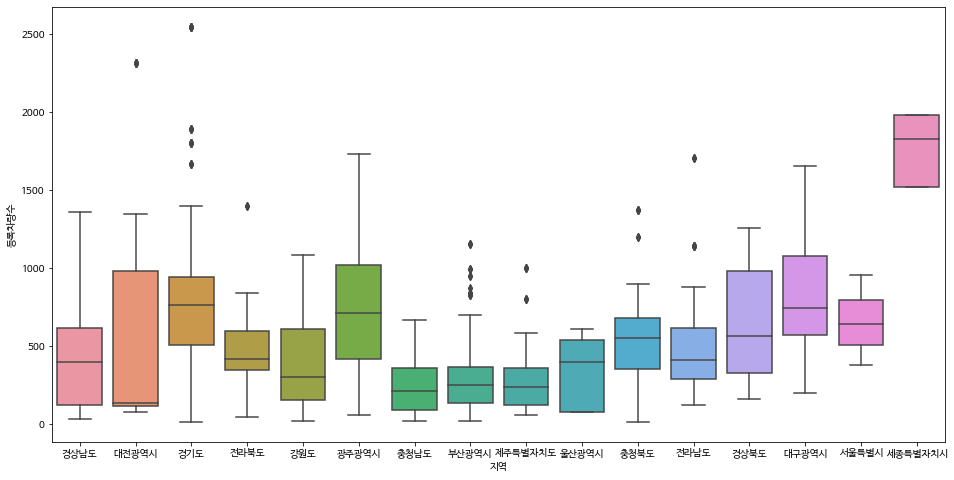

In [ ]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='지역', y='등록차량수', data=train)
plt.show()

In [ ]:
# 지역별 샘플수(count)와 등록차량수의 중앙값(median)을 산출한 후 이를 기준으로 정렬
area_groups = pd.DataFrame([
    *pd.DataFrame({
        '지역' : train['지역'],
        '등록차량수' : train['등록차량수'],
    })
    .groupby(['지역']).apply(lambda x: {
        '지역' : x.iloc[0, 0],
        'count' : len(x),
        'median' : x.등록차량수.median()
    })
]).sort_values('median')

area_groups

,지역,count,median
6,대전광역시,266,133.0
14,충청남도,158,209.0
13,제주특별자치도,91,235.0
7,부산광역시,328,251.0
0,강원도,187,302.0
10,울산광역시,34,396.0
2,경상남도,363,398.0
11,전라남도,147,408.0
12,전라북도,109,415.0
15,충청북도,163,553.0


In [ ]:
# 중앙값이 작은 지역부터 누적 샘플크기(cum_count)를 토대로 백분위수를 고려하여 5개 그룹으로 분할
area_groups['cum_count'] = np.cumsum(area_groups['count'])
area_groups['n지역'] = pd.qcut(area_groups['cum_count'], 5, labels=False, retbins=False)

area_groups

,지역,count,median,cum_count,n지역
6,대전광역시,266,133.0,266,0
14,충청남도,158,209.0,424,0
13,제주특별자치도,91,235.0,515,0
7,부산광역시,328,251.0,843,0
0,강원도,187,302.0,1030,1
10,울산광역시,34,396.0,1064,1
2,경상남도,363,398.0,1427,1
11,전라남도,147,408.0,1574,2
12,전라북도,109,415.0,1683,2
15,충청북도,163,553.0,1846,2


In [ ]:
to_join = area_groups[['지역', 'n지역']].set_index('지역')
train = train.join(to_join, on='지역')
train['n지역'] = train['n지역'].astype('category')

train = train[['단지코드', '총세대수', '임대건물구분', '지역', 'n지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형', '임대보증금', '임대료', '지하철', '버스', '단지내주차면수', '등록차량수']]
train.head(3)

,단지코드,총세대수,임대건물구분,지역,n지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
8,C2515,545,아파트,경상남도,1,국민임대,33.48,276,17.0,A,9216000,82940,0,3,624.0,205.0
9,C2515,545,아파트,경상남도,1,국민임대,39.60,60,17.0,A,12672000,107130,0,3,624.0,205.0
10,C2515,545,아파트,경상남도,1,국민임대,39.60,20,17.0,A,12672000,107130,0,3,624.0,205.0


In [ ]:
# test 데이터의 5번째 칼럼으로 n지역 칼럼을 추가
test.insert(4, 'n지역','') # insert(위치, 칼럼명, 내용)
test.head(3)

,단지코드,총세대수,임대건물구분,지역,n지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
0,C1072,754,아파트,경기도,,국민임대,39.79,116,14.0,H,22830000,189840,0,2.0,683.0
1,C1072,754,아파트,경기도,,국민임대,46.81,30,14.0,A,36048000,249930,0,2.0,683.0
2,C1072,754,아파트,경기도,,국민임대,46.90,112,14.0,H,36048000,249930,0,2.0,683.0


In [ ]:
# test 데이터의 n지역 칼럼을 구분한 지역별 값으로 채우기
test.loc[(test['지역']=='대전광역시')|(test['지역']=='충청남도')|(test['지역']=='부산광역시')|(test['지역']=='제주특별자치도'), 'n지역'] = 0
test.loc[(test['지역']=='강원도')|(test['지역']=='경상남도')|(test['지역']=='울산광역시'), 'n지역'] = 1
test.loc[(test['지역']=='전라남도')|(test['지역']=='전라북도')|(test['지역']=='충청북도'), 'n지역'] = 2
test.loc[(test['지역']=='경상북도')|(test['지역']=='광주광역시')|(test['지역']=='서울특별시'), 'n지역'] = 3
test.loc[(test['지역']=='경기도')|(test['지역']=='대구광역시')|(test['지역']=='세종특별자치시'), 'n지역'] = 4

test['n지역'] = test['n지역'].astype('category')

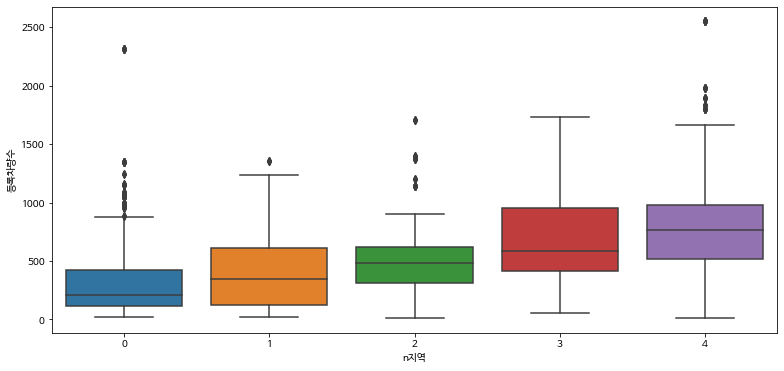

In [ ]:
plt.figure(figsize=(13, 6))
sns.boxplot(x='n지역', y='등록차량수', data=train)
plt.show()

### 2. 데이터 전처리
### 2-5. 파생변수 생성
2) **공급유형**
- 공급유형 피처 수준이 10개로 비교적 많은 편에 속한다.
- '**등록차량수-단지내주차면수**' 차이를 기준으로 하여 **공급유형을 5개의 그룹으로 통합**한다.
 - 0 : 국민임대
 - 1 : 단기공공임대(공공임대(5년)/공공임대(10년)/공공임대(분납)/공공분양)
 - 2 : 임대상가
 - 3 : 장기공공임대(공공임대(50년))
 - 4 : 저소득층(행복주택/영구임대/장기전세)

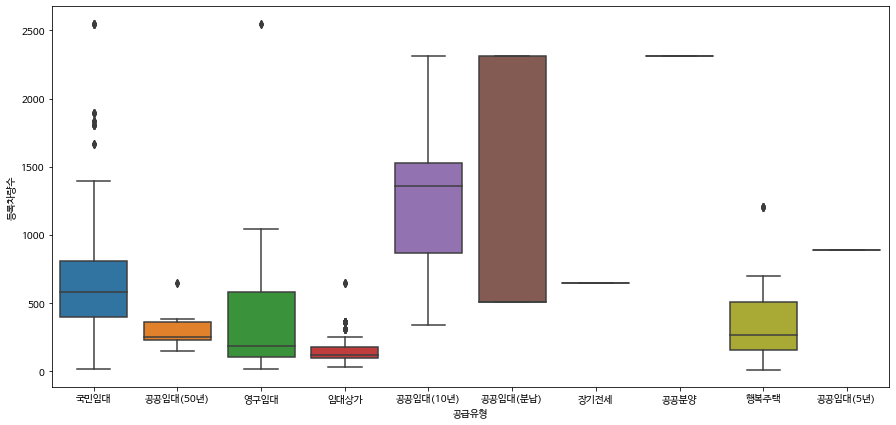

In [ ]:
plt.figure(figsize=(15, 7))
sns.boxplot(x='공급유형', y='등록차량수', data=train)
plt.show()

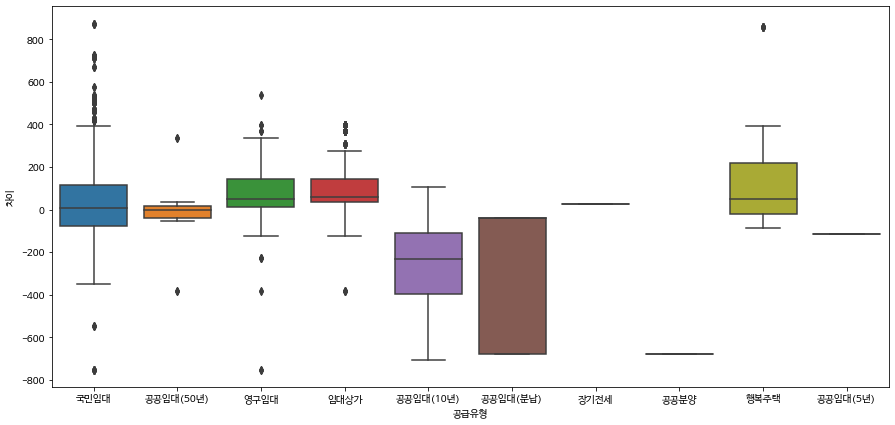

In [ ]:
tmp = train.copy()
tmp['차이'] = tmp['단지내주차면수'] - tmp['등록차량수']

plt.figure(figsize=(15, 7))
sns.boxplot(x='공급유형', y='차이', data=tmp)
plt.show()

### 2. 데이터 전처리
### 2-5. 파생변수 생성
2) **공급유형**
- 공급유형 별로 임대유형, 임대기간, 입주조건 등이 상이하다. 차량 보유 여부를 비롯한 **사회경제적지위(SES)를 반영**할 것으로 예상한다.
- 공급유형 별 특성과 '등록차량수-단지내주차면수' 차이 분포를 고려하여 범주를 분류한다.
- 가장 많은 공급유형인 **국민임대**와 아파트와 명확한 임대유형의 차이를 가진 **임대상가**는 **별도의 범주로 분류**한다.
 - 0 : 국민임대
 - 1 : 단기공공임대(공공임대(5년)/공공임대(10년)/공공임대(분납)/공공분양)
 - 2 : 임대상가
 - 3 : 장기공공임대(공공임대(50년))
 - 4 : 저소득층(행복주택/영구임대/장기전세)
- 공급유형을 **`astype('category').cat`**를 이용하여 카테고리형 변수로 변환하고 각 범주가 고유의 번호를 갖도록 설정한 후 **`codes`**를 이용하여 값을 구하여 **n공급유형**이라는 새로운 칼럼을 생성한다.

In [ ]:
train.loc[train['공급유형'].isin(['공공임대(50년)']), '공급유형'] = '장기공공임대'
train.loc[train['공급유형'].isin(['공공임대(5년)', '공공임대(10년)', '공공임대(분납)', '공공분양']), '공급유형'] = '단기공공임대'
train.loc[train['공급유형'].isin(['행복주택', '영구임대', '장기전세']), '공급유형'] = '저소득층'

test.loc[test['공급유형'].isin(['공공임대(50년)']), '공급유형'] = '장기공공임대'
test.loc[test['공급유형'].isin(['공공임대(5년)', '공공임대(10년)', '공공임대(분납)', '공공분양']), '공급유형'] = '단기공공임대'
test.loc[test['공급유형'].isin(['행복주택', '영구임대', '장기전세']), '공급유형'] = '저소득층'

In [ ]:
train.loc[:, '공급유형'].astype('category').cat.codes

8       0
9       0
10      0
11      0
12      0
       ..
2947    0
2948    0
2949    0
2950    0
2951    0
Length: 2876, dtype: int8

In [ ]:
train['n공급유형'] = train.loc[:, '공급유형'].astype('category').cat.codes
test['n공급유형'] = test.loc[:, '공급유형'].astype('category').cat.codes

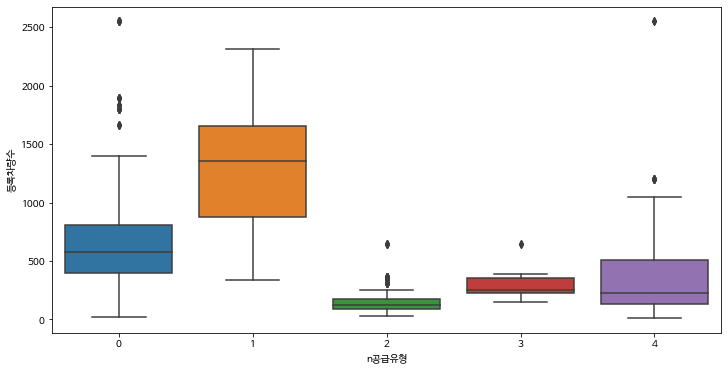

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='n공급유형', y='등록차량수', data=train)
plt.show()

### 2. 데이터 전처리
### 2-5. 파생변수 생성
3) **전용면적**
- 전용면적이 100 초과 -> **100**
- 전용면적이 15 미만 -> **15**

In [ ]:
# // 을 이용하여 나눗셈의 몫을 구해 정수화한다.
train['전용면적'] = train['전용면적']//5*5   
train['전용면적'] = np.where(train['전용면적'] > 100, 100, train['전용면적'])
train['전용면적'] = np.where(train['전용면적'] < 15, 15, train['전용면적'])

test['전용면적'] = test['전용면적']//5*5
test['전용면적'] = np.where(test['전용면적'] > 100, 100, test['전용면적'])
test['전용면적'] = np.where(test['전용면적'] < 15, 15, test['전용면적'])

### 2. 데이터 전처리
### 2-6. 1차원으로 데이터 병합
- '**공급유형**' 내에 '**임대건물구분**', '**자격유형**'에 대한 정보가 포함되어 있는 것으로 보이므로, **다중공선성**을 고려하여 **피처에서 제외**한다.
- raw 데이터 상 '**총세대수**' 산정 오류가 존재하므로, **기존 피처를 제외**하고 '**전용면적별세대수**'를 활용하여 '**총임대세대수**'라는 **대체 변수를 생성**한다.
- '**전용면적별세대수**', '**전용면적**', '**임대보증금**', '**임대료**'를 활용하여 파생변수를 추가로 생성한다.
 - 사용 피처 : 단지코드 / n지역 / n공급유형 / 공가수 / 지하철 / 버스 / 단지내주차면수 / 등록차량수
 - 제외 피처 : 임대건물구분 / 자격유형 / 총세대수
 - 추가 생성 피처 : 총임대세대수 / 평균전용면적 / 총전용면적 / 평균임대보증금 / 평균임대료

In [ ]:
codes = train['단지코드'].unique()
areas = np.sort(train['전용면적'].unique())

df_train = pd.DataFrame()
columns = ['단지코드', 'n지역', 'n공급유형', '공가수', '지하철', '버스', '단지내주차면수' , '등록차량수']

for i, code in enumerate(codes):
    tmp_code = train.loc[train['단지코드']==code].reset_index(drop=True)
    
    df_train.loc[i, columns] = tmp_code.loc[0, columns]
    df_train.loc[i, '총임대세대수'] = tmp_code['전용면적별세대수'].sum()
    df_train.loc[i, '평균전용면적'] = tmp_code['전용면적'].mean()
    df_train.loc[i, '총전용면적'] = (tmp_code['전용면적'] * tmp_code['전용면적별세대수']).sum()
    df_train.loc[i, '평균임대보증금'] = (tmp_code['전용면적별세대수'] * tmp_code['임대보증금']).sum() / tmp_code['전용면적별세대수'].sum()
    df_train.loc[i, '평균임대료'] = (tmp_code['전용면적별세대수'] * tmp_code['임대료']).sum() / tmp_code['전용면적별세대수'].sum()

In [ ]:
codes = test['단지코드'].unique()
areas = np.sort(test['전용면적'].unique())

df_test = pd.DataFrame()
columns = ['단지코드', 'n지역', 'n공급유형', '공가수', '지하철', '버스', '단지내주차면수']

for i, code in enumerate(codes):
    tmp_code = test.loc[test['단지코드']==code].reset_index(drop=True)
    
    df_test.loc[i, columns] = tmp_code.loc[0, columns]
    df_test.loc[i, '총임대세대수'] = tmp_code['전용면적별세대수'].sum()
    df_test.loc[i, '평균전용면적'] = tmp_code['전용면적'].mean()
    df_test.loc[i, '총전용면적'] = (tmp_code['전용면적'] * tmp_code['전용면적별세대수']).sum()
    df_test.loc[i, '평균임대보증금'] = (tmp_code['전용면적별세대수'] * tmp_code['임대보증금']).sum() / tmp_code['전용면적별세대수'].sum()
    df_test.loc[i, '평균임대료'] = (tmp_code['전용면적별세대수'] * tmp_code['임대료']).sum() / tmp_code['전용면적별세대수'].sum()

### 3. 모형 학습, 예측 및 평가
### 3-1. **단순 회귀(Linear Regression)**
1) 피처와 타겟 간 상관 확인
-  단순선형회귀를 수행하기 전, 피처와 타겟인 **등록차량수** 칼럼 간의 상관관계를 확인하여 회귀 분석의 가능성을 확인한다.
 - 높은 상관 -> 단지내주차면수, 총전용면적, 총임대세대수
 - 중간 상관 -> 평균임대료, 평균전용면적, 평균임대보증금, n지역, n공급유형
 - 낮은 상관 -> 공가수, 버스, 지하철

In [ ]:
corr = df_train.corr()['등록차량수'].sort_values(ascending=False)
corr

등록차량수      1.000000
단지내주차면수    0.847906
총전용면적      0.798962
총임대세대수     0.578065
평균임대료      0.452189
평균전용면적     0.392980
평균임대보증금    0.362990
n지역        0.322541
공가수        0.177878
버스         0.115073
지하철       -0.008515
n공급유형     -0.322437
Name: 등록차량수, dtype: float64

### 3. 모형 학습, 예측 및 평가
### 3-1. **단순 회귀(Linear Regression)**
2) 초기 모형 학습 및 평가
- 11개의 **모든 피처를 투입**하여 초기 모형의 학습 및 평가를 수행한다.
- StandardScaler를 이용하여 표준화를 진행한다. 초기 모형의 예측 성능과 5fold 교차검정을 통한 모형 평가 결과에 따르면 학습에 사용되는 데이터에 따라 예측 결과에 큰 영향이 미칠 것으로 예상된다.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaling_features = ['n지역' ,'n공급유형', '공가수', '지하철', '버스', '단지내주차면수', '총임대세대수', '평균전용면적', '총전용면적', '평균임대보증금', '평균임대료']

tmp_train = df_train.copy()
tmp_train.loc[:, scaling_features] = scaler.fit_transform(tmp_train[scaling_features])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

X_data = tmp_train.drop(['단지코드', '등록차량수'], axis=1, inplace=False)
y_target = tmp_train['등록차량수']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, shuffle=False, random_state=123, test_size=0.1)

model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

print(f'R2 score : {r2_score(pred, y_test)}, MAE : {mean_absolute_error(pred, y_test)}')

R2 score : 0.8510386124431302, MAE : 109.92051574556282


In [ ]:
from sklearn.model_selection import cross_val_score
mae_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_absolute_error', cv=5)
avg_mae = np.mean(mae_scores)

print("5Fold 개별 MAE score : ", mae_scores)
print("5Fold 평균 MAE : ", avg_mae)

5Fold 개별 MAE score :  [-238.96340483 -110.66110408  -90.50790683 -130.17935303 -148.11245629]
5Fold 평균 MAE :  -143.68484501271064


### 3. 모형 학습, 예측 및 평가
### 3-1. **단순 회귀(Linear Regression)**
3) 회귀계수 확인을 통한 모형 검토
- 정적 회귀 계수 피처 : n지역 / n공급유형 / 버스 / 단지내주차면수 / 평균전용면적 / 총전용면적 / 평균임대료
- 부적 회귀계수 피처 : 공가수 / 지하철 / 총임대세대수 / 평균임대보증금

In [ ]:
coef = pd.Series(model.coef_, index=X_data.columns)
coef

n지역         51.778763
n공급유형        0.153727
공가수        -37.455600
지하철        -15.230694
버스           4.527867
단지내주차면수    260.725414
총임대세대수    -112.308685
평균전용면적       8.774518
총전용면적      181.324184
평균임대보증금     -9.935424
평균임대료       28.898273
dtype: float64

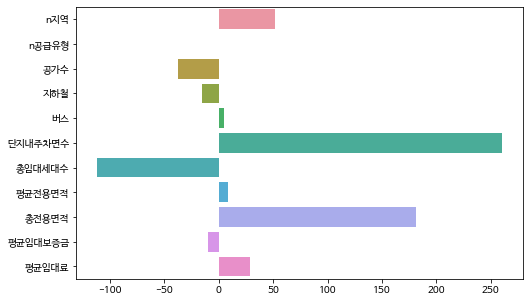

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x=coef.values, y=coef.index)
plt.show()

### 3. 모형 학습, 예측 및 평가
### 3-1. **단순 회귀(Linear Regression)**
4) permutation importance를 통한 피처 중요도 검토
- 사이킷런의 **`inspection`**으로부터 **`permutation_importance`**를 임포트하여 주요 피처를 살펴볼 수 있다.
- permutation importance에 따른 주요 피처로는 **단지내주차면수**, **총전용면적**, **총임대세대수**가 있다.

In [ ]:
from sklearn.inspection import permutation_importance

pmt_columns = ['n지역', 'n공급유형', '공가수', '지하철', '버스', '단지내주차면수', '총임대세대수', '평균전용면적', '총전용면적', '평균임대보증금', '평균임대료']
target = '등록차량수'

X_pmt = df_train.loc[:, pmt_columns]
y_pmt = df_train.loc[:, target]
X_pmt_train, X_pmt_val, y_pmt_train, y_pmt_val = train_test_split(X_pmt, y_pmt, random_state=123, test_size=0.1)

model = LinearRegression()
model.fit(X_pmt_train, y_pmt_train)
y_pmt_pred = model.predict(X_pmt_val)

r = permutation_importance(model, X_pmt_val, y_pmt_val, n_repeats=100, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:  # 이 조건을 만족하는 칼럼은 단지내주차면수, 총전용면적, 총임대세대수 3개
        print(X_pmt.columns[i], "     ", np.round(r.importances_mean[i], 4), " +/- ", np.round(r.importances_std[i], 5))

단지내주차면수       0.779  +/-  0.15402
총전용면적       0.5273  +/-  0.1295
총임대세대수       0.3702  +/-  0.08431


### 3. 모형 학습, 예측 및 평가
### 3-2. **다항 회귀(Polynomial Regression)**
1) 상호작용항 생성
- 상관, 회귀, permutation importance를 기반으로 최종 피처를 선정한다.
 - permutation importance에 따른 주요 피처는 단지내주차면수, 총전용면적, 총임대세대수이다.
 - 총전용면적은 다중공선성을 고려하여 평균전용면적으로 대체한다.
 - 상관이 낮은 버스와 지하철은 제외한다.
 - 회귀계수가 큰 순서대로 투입한 결과, 평균임대보증금과 평균임대료의 개선 효과가 미미하므로 제외한다.
- 최종적으로 **단지내주차면수**, **총임대세대수** + **평균전용면적**, **n지역**, **공가수**, **공급유형**을 선택한다.
- 사이킷런의 **`preprocessing`**의 **`PolynomialFeatures`** 클래스를 활용하여 가장 적절한 **2차식**으로 표현한다.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

columns = ['단지내주차면수', '총임대세대수', '평균전용면적', 'n지역', '공가수', 'n공급유형']
target = '등록차량수'

X = df_train.loc[:, columns]
y = df_train.loc[:, target]
X_val = df_test.loc[:, columns]

cat_features = ['n지역', 'n공급유형']
X = X.astype(dict((feature, 'category') for feature in cat_features))
X_val = X_val.astype(dict((feature, 'category') for feature in cat_features))

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = pd.DataFrame(poly.fit_transform(X))
X_val_poly = pd.DataFrame(poly.transform(X_val))

X.shape, X_poly.shape, X_val_poly.shape

((412, 6), (412, 27), (150, 27))

In [ ]:
poly.get_feature_names()

['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x3^2',
 'x3 x4',
 'x3 x5',
 'x4^2',
 'x4 x5',
 'x5^2']

### 4. 모형 개선
### 4-1. 가중치 생성
1) **Cook's D**를 활용한 가중치
- Cook's Distance: 각 관측값이 전체 최소제곱추정량에 미치는 영향력을 보여주는 통계적 지표로, **값이 클수록 회귀모형에 큰 영향**을 주는 샘플이다. 주로 이상치 탐지(outlier detection)에 사용된다.
- Cook's D 값이 큰 샘플에 작은 가중치를, Cook's D 값이 작은 샘플에 큰 가중치를 부여하면 예측력이 더 향상될 것이라고 가정하였다.
- Cook's D 값의 크기에 따라 역순으로 0에서 1 사이의 가중치를 생성하여 부여한다.

In [ ]:
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm

OLS = sm.OLS(y, X_poly)
result = OLS.fit()
influence = OLSInfluence(result)

weight = (influence.cooks_distance[0]).to_numpy()

for i in range(len(weight)):
    if weight[i] < 0.00000001:
        weight[i] = 0.9
    elif weight[i] < 0.0000001:
        weight[i] = 0.8
    elif weight[i] < 0.000001:
        weight[i] = 0.7
    elif weight[i] < 0.00001:
        weight[i] = 0.6
    elif weight[i] < 0.0001:
        weight[i] = 0.5
    elif weight[i] < 0.001:
        weight[i] = 0.4
    elif weight[i] < 0.01:
        weight[i] = 0.3
    elif weight[i] < 0.1:
        weight[i] = 0.2
    else:
        weight[i] = 0.1

### 4. 모형 개선
### 4-2. **교차검증(Stratified KFold)**
- 5Fold 교차검증을 이용하여 모델 학습 및 예측을 수행한다.

In [ ]:
from sklearn.model_selection import StratifiedKFold
y_cat = pd.cut(y, 10, labels=range(10))
skf = StratifiedKFold(5)
LR = LinearRegression()

preds = []
for tr_id, val_id in skf.split(X_poly, y_cat):
    X_tr = X_poly.iloc[tr_id]
    y_tr = y.iloc[tr_id]
    weight_tr = weight[tr_id]

    LR.fit(X_tr, y_tr, sample_weight=weight_tr)
    pred = LR.predict(X_val_poly)
    preds.append(pred)

LR_pred = np.mean(preds, axis=0)

### 5. 최종 결과 제출


In [ ]:
submission.head(3)

,code,num
0,C1072,0
1,C1128,0
2,C1456,0


In [ ]:
submission['num'] = LR_pred
submission.head()

,code,num
0,C1072,743.662907
1,C1128,1313.244550
2,C1456,443.557940
3,C1840,528.973509
4,C1332,1228.725135
